*Known Issues - pls fix*
- TODO: Sample size is small - need to duplicate transformed photos with data augmentation (prevent overfitting + better for transfer learning)

In [325]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import math

## Step 1: Calculate efficiency gaps for previous statewide election returns - this will serve as our target feature.

This dataset contains information on election results for statewide representative elections. This dataset uses the democratic party as the centerpiece party; the resulting effiency gap metric can be directionally interpreted - positive values favor the democratic party, while negative values favor the conservative party (known as GOP party).

Note: There are several reasons why congressional representative elections are used instead of presidential results:
1. There are third-party candidates in presidential elections that often steal sizeable votes away from either major party
2. Presidential election results by congressional district were not widely recorded until the 1970s ([MIT](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/42MVDX)).
3. Congressional elections are less prone to "strategic voting", as congressional representatives (serving in the House of Representatives) directly represent the interest of the district.

In [326]:
df = pd.read_csv("data\congressional_election_results_post1948.csv")

df.shape

(15228, 8)

In [327]:
# Remove erroneous districts - both sides have 0 votes
df = df[~(df["Dem Votes"] == df["GOP Votes"])]

# Remove 6 states with only 1 voting district - these states can't be gerrymandered
single_district_states = ["AK", "DE", "ND", "SD", "VT", "WY"]
df = df[~df["State"].isin(single_district_states)]

In [328]:
df.shape

(14991, 8)

In [329]:
df.head()

,State,Year,District,Dem Votes,GOP Votes,D Voteshare,Incumbent,Party
0,AL,1948,1,19778,0,1.000000,1,D
1,AL,1948,2,21271,0,1.000000,1,D
2,AL,1948,3,16279,0,1.000000,1,D
3,AL,1948,4,17282,3054,0.849823,1,D
4,AL,1948,5,20548,0,1.000000,1,D


In [330]:
df = df.drop(columns="Incumbent")

Creating efficiency gap metric (Methodology found [here](https://www.brennancenter.org/sites/default/files/legal-work/How_the_Efficiency_Gap_Standard_Works.pdf))

The process is as follows:  
1. Calculate "net wasted votes" for each district - the net amount wasted votes from each party (defined below/in README)
2. Sum the net wasted votes across all districts in a state
3. Divide net wasted votes by total votes

In [331]:
df["total_votes"] = df["Dem Votes"] + df["GOP Votes"]

In [332]:
# Net wasted votes = (wasted votes by winning party - 50+1 majority) - all votes by losing party

def net_wasted_votes(democrat_votes, gop_votes):

    majority = math.floor((democrat_votes + gop_votes) / 2) + 1 # required votes for majority  

    if democrat_votes >= gop_votes: 
        return (democrat_votes - majority) - gop_votes 
    else: 
        return -(gop_votes - majority) + democrat_votes 
        

In [333]:
# Positive values indicate wasted votes for democrats, negative values indicate wasted votes for republicans

df["net_wasted_votes"] = df.apply(lambda x: net_wasted_votes(x["Dem Votes"], x["GOP Votes"]), axis=1)

In [334]:
df.head(20)

,State,Year,District,Dem Votes,GOP Votes,D Voteshare,Party,total_votes,net_wasted_votes
0,AL,1948,1,19778,0,1.000000,D,19778,9888
1,AL,1948,2,21271,0,1.000000,D,21271,10635
2,AL,1948,3,16279,0,1.000000,D,16279,8139
3,AL,1948,4,17282,3054,0.849823,D,20336,4059
4,AL,1948,5,20548,0,1.000000,D,20548,10273
5,AL,1948,6,13968,2994,0.823488,D,16962,2492
6,AL,1948,7,21552,0,1.000000,D,21552,10775
7,AL,1948,8,19060,2510,0.883635,D,21570,5764
8,AL,1948,9,33781,5006,0.870936,D,38787,9381
9,AZ,1948,1,42565,29864,0.587679,D,72429,-23514


In [335]:
# Group results by year and state - efficiency gap should be calculated state wide
# each row is one state per election cycle

df_grouped = df.groupby(["Year", "State"]).agg({
    'District': 'count',
    'Dem Votes': 'sum',
    'GOP Votes': 'sum',
    'Party': 'sum',
    'total_votes': 'sum',
    'net_wasted_votes': 'sum'
    }).reset_index()

In [336]:
df_grouped = df_grouped.rename(columns={"District": "total_districts", "Dem Votes": "state_total_dem_votes",
                   "GOP Votes": "state_total_gop_votes", "total_votes": "state_total_votes",
                   "net_wasted_votes": "state_net_wasted_votes"})

In [337]:
df_grouped["efficiency_gap"] = round(df_grouped["state_net_wasted_votes"] / df_grouped["state_total_votes"], 2)

In [338]:
df_grouped["dem_state_voteshare"] = round((df_grouped["state_total_dem_votes"] / df_grouped["state_total_votes"]), 2)

In [339]:
df_grouped["dem_state_seatshare"] = df_grouped["Party"].apply(lambda x: round(x.count("D") / len(x), 2))

In [340]:
df_grouped = df_grouped.drop(columns="Party")

In [341]:
df_grouped.head()

,Year,State,total_districts,state_total_dem_votes,state_total_gop_votes,state_total_votes,state_net_wasted_votes,efficiency_gap,dem_state_voteshare,dem_state_seatshare
0,1948,AL,9,183519,13564,197083,71406,0.36,0.93,1.00
1,1948,AR,7,230927,0,230927,115457,0.50,1.00,1.00
2,1948,AZ,2,96631,60004,156635,-41692,-0.27,0.62,1.00
3,1948,CA,23,1351731,1976923,3328654,-453818,-0.14,0.41,0.43
4,1948,CO,4,272484,224927,497411,-62703,-0.13,0.55,0.75


**Positive efficiency gap = better for republicans, negative efficiency gap = better for democrats**

Positive efficiency gap values benefit republicans (lots of net wasted democrat votes), and vice versa

In [343]:
# All voting competitions without empty seats (non-unanimous voting)
df_non_empty = df_grouped[(df_grouped["state_total_dem_votes"] != 0) & (df_grouped["state_total_gop_votes"] != 0)]

# Remove remaining single-district states - cannot be gerrymandered
df_non_empty = df_non_empty[df_non_empty["total_districts"] > 1]

df_non_empty.shape

(1483, 10)

In [344]:
# TODO: add gradient column for cloropleth (try population, minority population, etc.)
vote_df = df.merge(df_non_empty, how="left", on=["Year", "State"])

# Remove remaining single-district states - cannot be gerrymandered
vote_df = vote_df[vote_df["total_districts"] > 1]

vote_df

,State,Year,District,Dem Votes,GOP Votes,D Voteshare,Party,total_votes,net_wasted_votes,total_districts,state_total_dem_votes,state_total_gop_votes,state_total_votes,state_net_wasted_votes,efficiency_gap,dem_state_voteshare,dem_state_seatshare
0,AL,1948,1,19778,0,1.000000,D,19778,9888,9.0,183519.0,13564.0,197083.0,71406.0,0.36,0.93,1.00
1,AL,1948,2,21271,0,1.000000,D,21271,10635,9.0,183519.0,13564.0,197083.0,71406.0,0.36,0.93,1.00
2,AL,1948,3,16279,0,1.000000,D,16279,8139,9.0,183519.0,13564.0,197083.0,71406.0,0.36,0.93,1.00
3,AL,1948,4,17282,3054,0.849823,D,20336,4059,9.0,183519.0,13564.0,197083.0,71406.0,0.36,0.93,1.00
4,AL,1948,5,20548,0,1.000000,D,20548,10273,9.0,183519.0,13564.0,197083.0,71406.0,0.36,0.93,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14986,WI,2016,4,220181,0,1.000000,D,220181,110090,8.0,1379996.0,1270279.0,2650275.0,559693.0,0.21,0.52,0.38
14987,WI,2016,5,114477,260706,0.305123,R,375183,41363,8.0,1379996.0,1270279.0,2650275.0,559693.0,0.21,0.52,0.38
14988,WI,2016,6,133072,204147,0.394616,R,337219,97535,8.0,1379996.0,1270279.0,2650275.0,559693.0,0.21,0.52,0.38
14989,WI,2016,7,138643,223418,0.382927,R,362061,96256,8.0,1379996.0,1270279.0,2650275.0,559693.0,0.21,0.52,0.38


In [345]:
vote_df.to_csv("intermediate/efficiency_gap_by_congressional_district_post_1948.csv")

In [346]:
# Large effiency gap values in both directions indicate either "overkill" winning (packing) or close loss (cracking)
df_non_empty.sort_values(by="efficiency_gap")

,Year,State,total_districts,state_total_dem_votes,state_total_gop_votes,state_total_votes,state_net_wasted_votes,efficiency_gap,dem_state_voteshare,dem_state_seatshare
297,1960,UT,2,186710,182752,369462,-180775,-0.49,0.51,1.00
1123,1998,NV,2,79315,275163,354478,-171464,-0.48,0.22,0.50
1516,2016,NH,2,336214,315971,652185,-305851,-0.47,0.52,1.00
113,1952,NM,2,241402,221892,463294,-212139,-0.46,0.52,1.00
1428,2012,NH,2,340925,311636,652561,-296993,-0.46,0.52,1.00
...,...,...,...,...,...,...,...,...,...,...
368,1964,MS,5,325950,35277,361227,173391,0.48,0.90,0.80
1109,1998,LA,7,94203,97048,191251,92780,0.49,0.49,0.29
1181,2000,WV,3,420784,108769,529553,259010,0.49,0.79,0.67
43,1950,AL,9,151212,980,152192,74129,0.49,0.99,1.00


Stephanopoulos and McGhee argue that 7% is the threshold for the efficiency gap metric - values higher in magnitude in either direction mean that the state is gerrymandered.

In [347]:
pct_gerrymandered = df_non_empty[(df_non_empty["efficiency_gap"] < -0.07) | (df_non_empty["efficiency_gap"] > 0.07)].shape[0] / df_non_empty.shape[0]
pct_gerrymandered_rep = df_non_empty[(df_non_empty["efficiency_gap"] > 0.07)].shape[0] / df_non_empty.shape[0]
pct_gerrymandered_dem = df_non_empty[(df_non_empty["efficiency_gap"] < -0.07)].shape[0] / df_non_empty.shape[0]


print(f" Percent of states gerrymandered: {round(pct_gerrymandered, 3) * 100}%")
print(f" Percent of states gerrymandered in favor of Republicans: {round(pct_gerrymandered_rep, 3) * 100}%")
print(f" Percent of states gerrymandered in favor of Democrats: {round(pct_gerrymandered_dem, 3) * 100}%")

 Percent of states gerrymandered: 62.2%
 Percent of states gerrymandered in favor of Republicans: 39.4%
 Percent of states gerrymandered in favor of Democrats: 22.7%


Text(0.5, 1.0, 'Bidirectional Efficiency Gap Histogram')

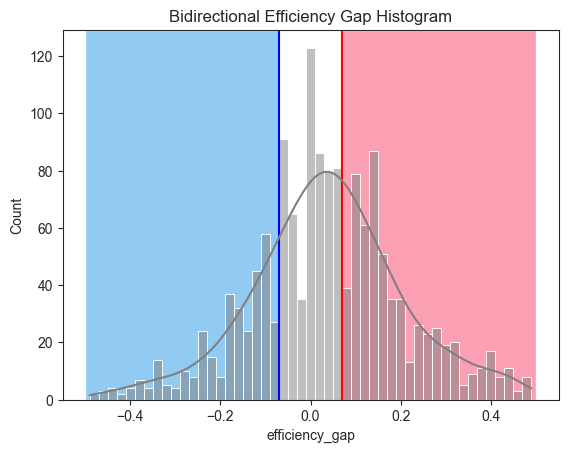

In [348]:
# Shading
plt.axvline(x=0.07, color='red')
plt.axvline(x=-0.07, color='blue')
plt.axvspan(xmin=0.07, xmax=0.5, facecolor='#faa0b2')
plt.axvspan(xmin=-0.5, xmax=-0.07, facecolor='#91caf2')

# Plot
sns.set_style('ticks')
g = sns.histplot(data=df_non_empty, x="efficiency_gap", binwidth=0.02, kde=True, color="grey")
g.set_title("Bidirectional Efficiency Gap Histogram")

# Gridlines
# plt.grid()

(0.0, 100.0)

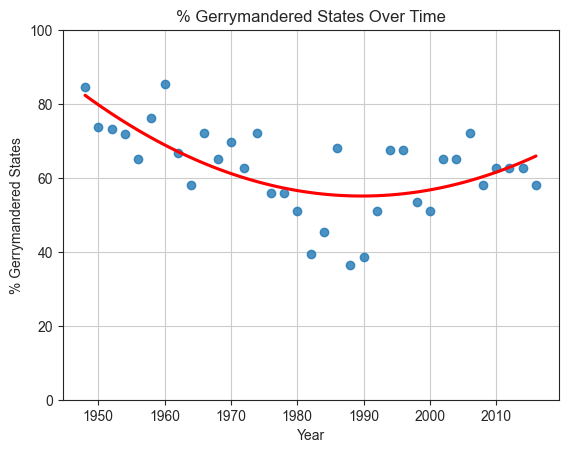

In [369]:
states_count = df_non_empty.groupby("Year").State.count()
gerrymander_state_count = df_non_empty[(df_non_empty["efficiency_gap"] < -0.07) | (df_non_empty["efficiency_gap"] > 0.07)].groupby("Year").State.count()
pct_gerrymander_ts = gerrymander_state_count / states_count

plt.grid()
g = sns.regplot(x=pct_gerrymander_ts.index, y=pct_gerrymander_ts*100, data=pct_gerrymander_ts, 
                order=2, ci=False, line_kws={"color": "red"})
g.set_title("% Gerrymandered States Over Time")
g.set_ylabel("% Gerrymandered States")
g.set_ylim(0, 100)

(-0.15, 0.15)

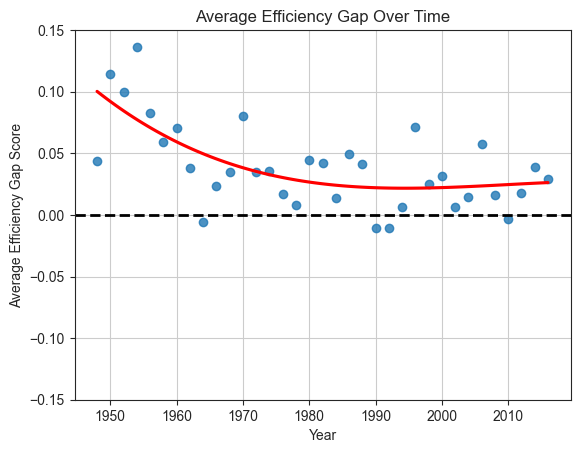

In [367]:
efficiency_gap_avg = df_non_empty.groupby("Year").efficiency_gap.mean()

plt.grid()
g = sns.regplot(x=efficiency_gap_avg.index, y=efficiency_gap_avg, data=efficiency_gap_avg, 
                order=3, ci=False, line_kws={"color": "red"})
plt.axhline(y=0, linestyle="--", color="black", linewidth=2)
g.set_title("Average Efficiency Gap Over Time")
g.set_ylabel("Average Efficiency Gap Score")
g.set_ylim(-0.15, 0.15)

Despite a relatively even occurance in gerrymandering over time, average efficiency score decreases over time, remaining slightly above 0. This indicates that both sides conduct gerrymandering in recent times, with Republicans as consistently worse offenders of gerrymandering. 

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 [Text(0, 0, '1948'),
  Text(1, 0, '1950'),
  Text(2, 0, '1952'),
  Text(3, 0, '1954'),
  Text(4, 0, '1956'),
  Text(5, 0, '1958'),
  Text(6, 0, '1960'),
  Text(7, 0, '1962'),
  Text(8, 0, '1964'),
  Text(9, 0, '1966'),
  Text(10, 0, '1968'),
  Text(11, 0, '1970'),
  Text(12, 0, '1972'),
  Text(13, 0, '1974'),
  Text(14, 0, '1976'),
  Text(15, 0, '1978'),
  Text(16, 0, '1980'),
  Text(17, 0, '1982'),
  Text(18, 0, '1984'),
  Text(19, 0, '1986'),
  Text(20, 0, '1988'),
  Text(21, 0, '1990'),
  Text(22, 0, '1992'),
  Text(23, 0, '1994'),
  Text(24, 0, '1996'),
  Text(25, 0, '1998'),
  Text(26, 0, '2000'),
  Text(27, 0, '2002'),
  Text(28, 0, '2004'),
  Text(29, 0, '2006'),
  Text(30, 0, '2008'),
  Text(31, 0, '2010'),
  Text(32, 0, '2012'),
  Text(33, 0, '2014'),
  Text(34, 0, '2016')])

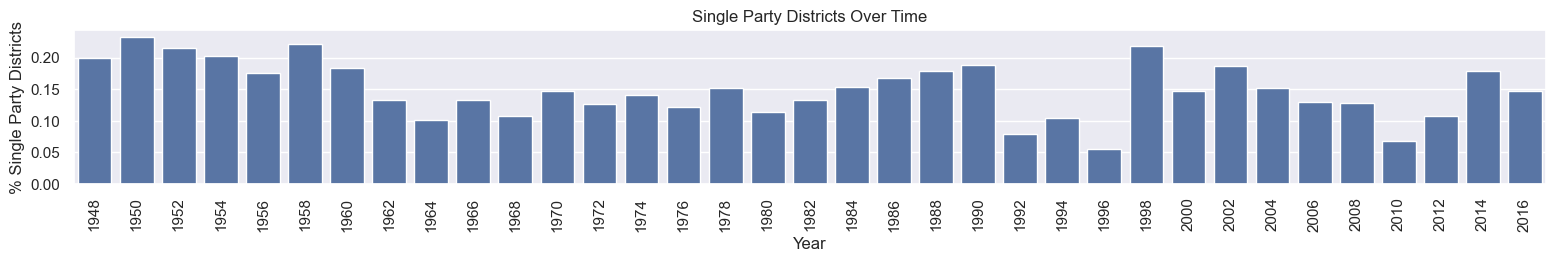

In [400]:
single_party_state = df[(df["Dem Votes"] == 0) | (df["GOP Votes"] == 0)]
single_party_districts = single_party_state.groupby("Year").District.count()
total_districts = df.groupby("Year").District.count()

pct_single_party = pd.DataFrame(single_party_districts/total_districts)

g = sns.barplot(x=pct_single_party.index, y="District", data=pct_single_party)
sns.set_theme(rc={'figure.figsize':(18, 2)})
g.set_title("Single Party Districts Over Time")
g.set_ylabel("% Single Party Districts")
plt.xticks(rotation=90)



No noticable trend in single-party districts (where one party does not field a candidate, and the single running candidate wins 100% of votes). We can leave these districts in for now.